# 0.0 Imports

In [1]:
# !pip install inflection
# !pip install pandas-profiling
# !pip install sweetviz
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
#import pandas-profile
# import sweetviz
from scipy import stats
from itertools import product

from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import model_selection as ms
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
test_data = pd.read_csv('work/test.csv')
train_data = pd.read_csv('work/train.csv')

X = train_data.drop(columns=['Satisfaction'])
y = train_data['Satisfaction'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df1 = pd.concat([x_train, y_train],axis=1)

In [4]:
def notebook_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

notebook_settings()

# 1.0 Descrição dos dados

In [5]:
df1.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
20921,37164,Female,Loyal Customer,59,Personal,Medium,1046,4,5,4,...,2,2,4,3,5,2,4,12,3.000,Neutral or Dissatisfaction
36897,43436,Female,disloyal Customer,40,Gift,Large,752,4,4,4,...,1,4,2,4,3,5,1,19,29.000,Neutral or Dissatisfaction
8468,5306,Male,Loyal Customer,65,Personal,Medium,383,2,3,2,...,1,5,4,5,5,5,1,0,0.000,Neutral or Dissatisfaction
53490,79161,Female,Loyal Customer,70,Personal,Medium,2239,3,5,3,...,5,5,3,5,3,5,5,0,0.000,Neutral or Dissatisfaction
78687,33333,Female,disloyal Customer,25,Gift,Medium,1358,2,2,2,...,1,1,2,3,5,2,1,3,15.000,Neutral or Dissatisfaction


In [6]:
df1.shape

(83123, 24)

In [7]:
# train data
old_cols = df1.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
df1.columns = new_cols

# val data
old_cols = x_val.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
x_val.columns = new_cols

# test data
old_cols = test_data.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
test_data.columns = new_cols

- Store distance - se refere a distância do cliente para a loja ou a distância da loja concorrente mais próxima

- InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.

 Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.

- Ter uma descrição das colunas com base no conhecimento de negocio de loja de roupas

- Self-store: poderia ser um painel para auto-atendimento

In [8]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
instore_wifi                    0
open_close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self-store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     251
satisfaction                    0
dtype: int64

- Hip 1: Quem não preencheu Delivery delay in minutes foi porque comprou em loja física

- Hip 2: Quem não preencheu Delivery delay in minutes foi porque estava insatisfeito

In [9]:
mean = df1['delivery_delay_in_minutes'].mean()

# train data
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].fillna(mean)
# val data
x_val['delivery_delay_in_minutes'] = x_val['delivery_delay_in_minutes'].fillna(mean)
# test data
test_data['delivery_delay_in_minutes'] = test_data['delivery_delay_in_minutes'].fillna(mean)

In [10]:
df1.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
instore_wifi                    int64
open_close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self-store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

In [11]:
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].astype('int64')

x_val['delivery_delay_in_minutes'] = x_val['delivery_delay_in_minutes'].astype('int64')

test_data['delivery_delay_in_minutes'] = test_data['delivery_delay_in_minutes'].astype('int64')

In [12]:
numerical_attributes = df1.select_dtypes(include='number')
categorical_attributes = df1.select_dtypes(exclude='number')

# Central tendency and Dispersion
d1 = pd.DataFrame (numerical_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = numerical_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
metrics = pd.concat([d1, d2]).T.reset_index()
metrics.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics = metrics[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,129879.000,129878.000,65059.540,65078.000,37425.968,-0.002,-1.197
1,age,7.000,85.000,78.000,39.341,40.000,15.124,0.001,-0.722
2,store_distance,31.000,4983.000,4952.000,1188.665,842.000,996.941,1.110,0.271
3,instore_wifi,0.000,5.000,5.000,2.730,3.000,1.328,0.037,-0.846
4,open_close_time_convenient,0.000,5.000,5.000,3.058,3.000,1.527,-0.333,-1.041
5,easy_of_online_shopping,0.000,5.000,5.000,2.759,3.000,1.399,-0.021,-0.909
6,store_location,0.000,5.000,5.000,2.978,3.000,1.277,-0.059,-1.027
7,toilet_cleaning,0.000,5.000,5.000,3.201,3.000,1.328,-0.150,-1.143
8,dressing_room,0.000,5.000,5.000,3.247,3.000,1.349,-0.451,-0.704
9,waiting_room,0.000,5.000,5.000,3.436,4.000,1.319,-0.478,-0.930


- age: 0 > 10 - 0
11 > 20 - 1

carrier_delay_in_minutes: horas
delivery_delay_in_minutes: horas

nota > frequency ou target

In [13]:
categorical_attributes.apply( lambda x: x.unique().shape[0])

gender              2
customer_type       2
type_of_purchase    2
store_size          3
satisfaction        2
dtype: int64

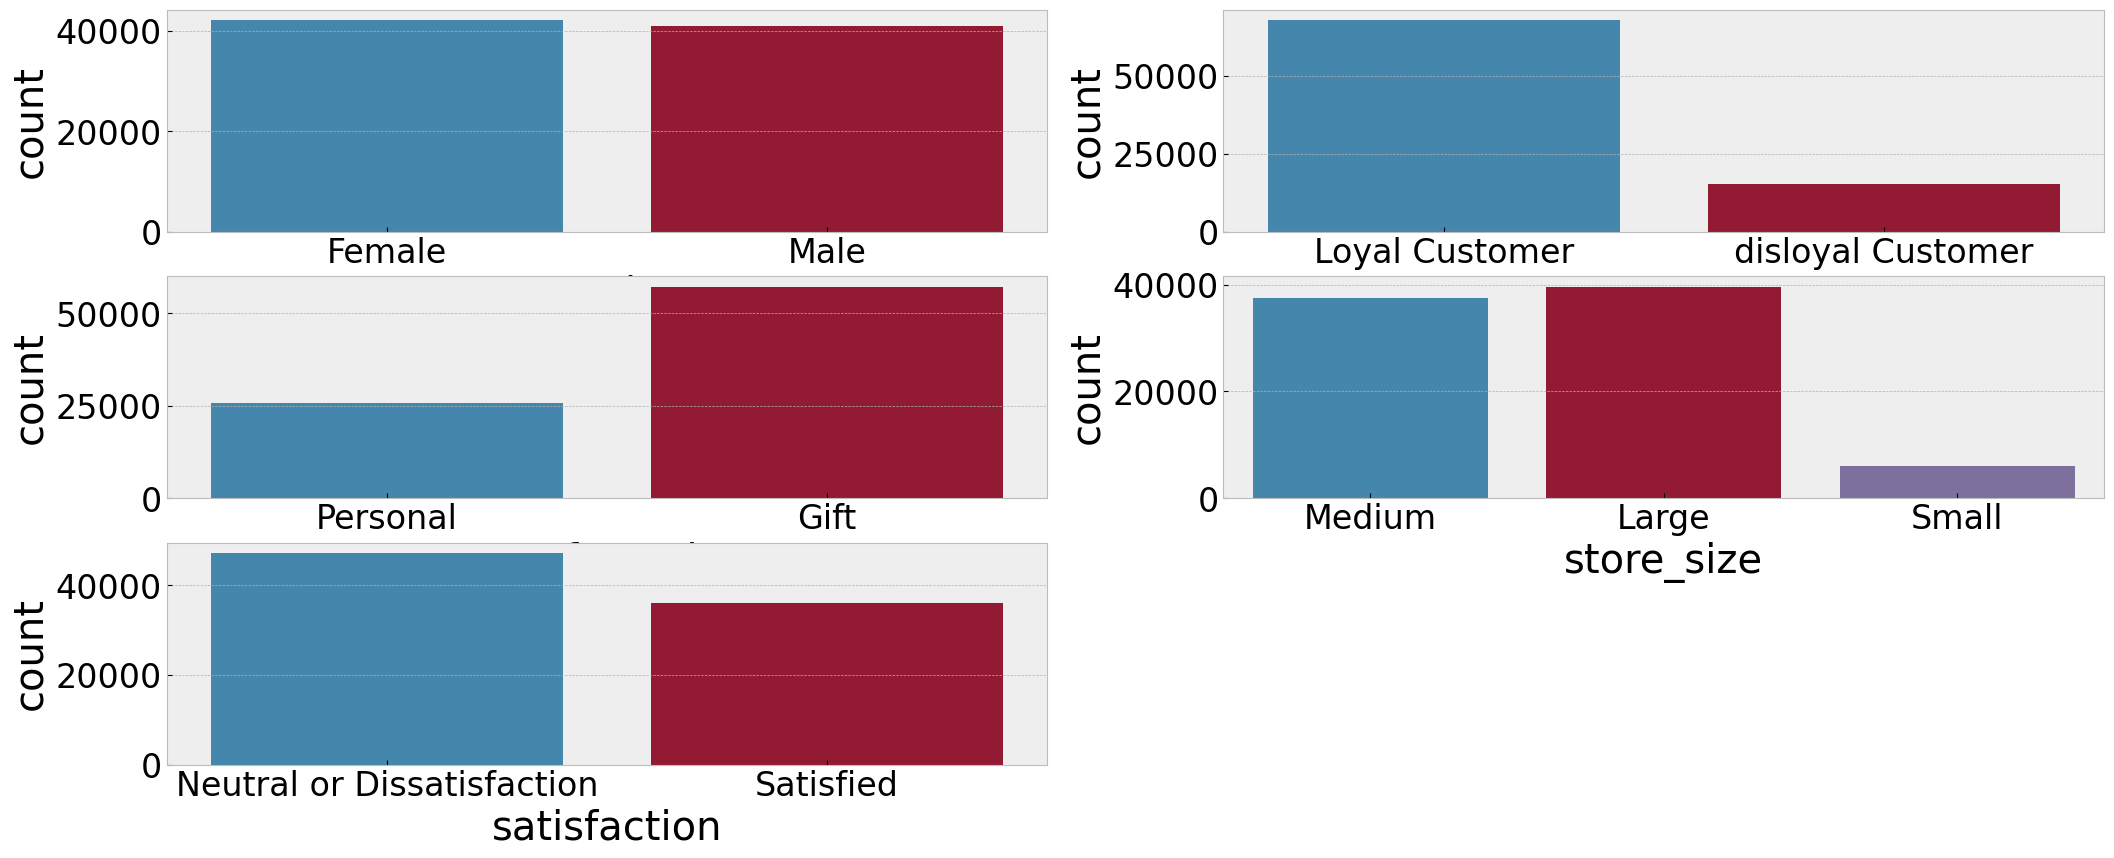

In [14]:
plt.subplot(3, 2, 1)
sns.countplot(x='gender', data=categorical_attributes)

plt.subplot(3, 2, 2)
sns.countplot(x='customer_type', data=categorical_attributes)

plt.subplot(3, 2, 3)
sns.countplot(x='type_of_purchase', data=categorical_attributes)

plt.subplot(3, 2, 4)
sns.countplot(x='store_size', data=categorical_attributes)

plt.subplot(3, 2, 5)
sns.countplot(x='satisfaction', data=categorical_attributes);

- verificar metragem padrão dos eua para store_distance afim de validar os valores máximos.

# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
df2['total_delay_minutes'] = df2['carrier_delay_in_minutes'] + df2['delivery_delay_in_minutes']
x_val['total_delay_minutes'] = x_val['carrier_delay_in_minutes'] + x_val['delivery_delay_in_minutes']
test_data['total_delay_minutes'] = test_data['carrier_delay_in_minutes'] + test_data['delivery_delay_in_minutes']

In [17]:
#Features criadas

# Calculando os quartis da coluna store_distance
q1 = df2['store_distance'].quantile(0.25)
q2 = df2['store_distance'].quantile(0.50)  # Mediana
q3 = df2['store_distance'].quantile(0.75)

# Função para categorizar a distância da loja em grupos
def categorize_distance(distance):
    if distance <= q1:
        return 'Perto'
    elif distance <= q2:
        return 'Médio'
    else:
        return 'Longe'

# Criando a coluna Distance_Range nos três dataframes
df2['Distance_Range'] = df2['store_distance'].apply(categorize_distance)
x_val['Distance_Range'] = x_val['store_distance'].apply(categorize_distance)
test_data['Distance_Range'] = test_data['store_distance'].apply(categorize_distance)

# Definindo o limite para considerar um atraso como "Long_Delay" (30 minutos, por exemplo)
limite_long_delay = 30

# Criando a coluna Long_Delay em df2
df2['Long_Delay'] = df2['total_delay_minutes'].apply(lambda x: x > limite_long_delay)
# Criando a coluna Long_Delay em x_val
x_val['Long_Delay'] = x_val['total_delay_minutes'].apply(lambda x: x > limite_long_delay)
# Criando a coluna Long_Delay em test_data
test_data['Long_Delay'] = test_data['total_delay_minutes'].apply(lambda x: x > limite_long_delay)

# Criando a coluna High_Rated_Dressing_Room em df2
df2['High_Rated_Dressing_Room'] = df2['dressing_room'].apply(lambda x: x > 3)
# Criando a coluna High_Rated_Dressing_Room em x_val
x_val['High_Rated_Dressing_Room'] = x_val['dressing_room'].apply(lambda x: x > 3)
# Criando a coluna High_Rated_Dressing_Room em test_data
test_data['High_Rated_Dressing_Room'] = test_data['dressing_room'].apply(lambda x: x > 3)

# Criando a coluna Customer_Type_Purchase em df2
df2['Customer_Type_Purchase'] = df2['customer_type'].str.cat(df2['type_of_purchase'], sep='_')
# Criando a coluna Customer_Type_Purchase em x_val
x_val['Customer_Type_Purchase'] = x_val['customer_type'].str.cat(x_val['type_of_purchase'], sep='_')
# Criando a coluna Customer_Type_Purchase em test_data
test_data['Customer_Type_Purchase'] = test_data['customer_type'].str.cat(test_data['type_of_purchase'], sep='_')

#Total_Services: Soma das pontuações para Seller service, Purchase service, Store Service.
df2['total_services'] = df2['seller_service'] + df2['purchase_service'] + df2['store_service']
x_val['total_services'] =  x_val['seller_service'] + x_val['purchase_service'] + x_val['store_service']
test_data['total_services'] = test_data['seller_service'] + test_data['purchase_service'] + test_data['store_service']

#Total_Online_Features: Soma das pontuações para InStore wifi, Easy of online shopping.
# df2['total_online_features'] = df2['instore_wifi'] + df2['easy_of_online_shopping'] 
# x_val['total_online_features'] =  x_val['instore_wifi'] + x_val['easy_of_online_shopping'] 
# test_data['total_online_features'] = test_data['instore_wifi'] + test_data['easy_of_online_shopping']

# 3.0 Filtragem de variáveis

In [18]:
df3 = df2.copy()

# 4.0 Análise exploratória dos dados

In [19]:
df4 = df3.copy()

#Ter uma descrição das colunas com base no conhecimento de negocio de loja de roupas

# AGE 
# relação com Kids entertainment ( crianças, Pais [30 anos])

#type_of_purchase



#Store distance
# se refere a distância do cliente para a loja ou a distância da loja concorrente mais próxima
# Investigar se existe alguma relação com store location/delivery_delay/open_close_time e a satisfação do cliente
# 

#InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.
#Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.
#  A média entre os clientes satisfeitos é menor 


#Self-store:
# poderia ser um painel para auto-atendimento
# Existe alguma relação entre o tamanho da loja e o autoatendimento com a satisfação do cliente

# Delivery_delay
#Hip 1: Quem não preencheu Delivery delay in minutes foi porque comprou em loja física
#Hip 2: Quem não preencheu Delivery delay in minutes foi porque estava insatisfeito

# Store_distance
#verificar metragem padrão dos eua para store_distance afim de validar os valores máximos.



In [20]:
linhas = df4["satisfaction"] == "Satisfied"
df_aux = df4.loc[linhas,:]
df_aux.describe()

,id,age,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,...,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,total_delay_minutes,total_services
count,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,...,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000
mean,65549.824,41.708,1530.166,3.159,2.970,3.032,2.978,3.520,4.025,3.964,...,3.859,3.823,3.964,3.648,3.967,3.738,12.574,12.589,25.163,11.474
std,37226.531,12.771,1128.307,1.590,1.555,1.578,1.376,1.235,1.195,1.145,...,1.125,1.174,1.101,1.158,1.093,1.145,35.511,36.059,70.894,2.418
min,2.000,7.000,31.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,3.000
25%,33655.000,32.000,526.000,2.000,2.000,2.000,2.000,3.000,4.000,4.000,...,3.000,3.000,4.000,3.000,4.000,3.000,0.000,0.000,0.000,10.000
50%,65959.000,43.000,1250.000,4.000,3.000,3.000,3.000,4.000,4.000,4.000,...,4.000,4.000,4.000,4.000,4.000,4.000,0.000,0.000,1.000,12.000
75%,97562.000,51.000,2404.000,5.000,4.000,4.000,4.000,5.000,5.000,5.000,...,5.000,5.000,5.000,5.000,5.000,5.000,9.000,8.000,17.000,13.000
max,129879.000,85.000,4983.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,...,5.000,5.000,5.000,5.000,5.000,5.000,1305.000,1280.000,2585.000,15.000


## 4.1 Analise Univariada

In [21]:
df4.describe()


,id,age,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,...,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,total_delay_minutes,total_services
count,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,...,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000
mean,65059.540,39.341,1188.665,2.730,3.058,2.759,2.978,3.201,3.247,3.436,...,3.384,3.354,3.630,3.306,3.639,3.282,14.852,15.209,30.061,10.329
std,37425.968,15.124,996.941,1.328,1.527,1.399,1.277,1.328,1.349,1.319,...,1.287,1.314,1.181,1.265,1.175,1.311,38.495,38.922,76.673,2.796
min,1.000,7.000,31.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
25%,32773.000,27.000,414.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,...,2.000,2.000,3.000,3.000,3.000,2.000,0.000,0.000,0.000,8.000
50%,65078.000,40.000,842.000,3.000,3.000,3.000,3.000,3.000,3.000,4.000,...,4.000,4.000,4.000,3.000,4.000,3.000,0.000,0.000,2.000,11.000
75%,97500.500,51.000,1739.000,4.000,4.000,4.000,4.000,4.000,4.000,5.000,...,4.000,4.000,5.000,4.000,5.000,4.000,12.000,13.000,24.000,13.000
max,129879.000,85.000,4983.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,...,5.000,5.000,5.000,5.000,5.000,5.000,1592.000,1584.000,3176.000,15.000


In [22]:
# my_report = sweetviz.analyze( df4 )
# my_report.show_html()

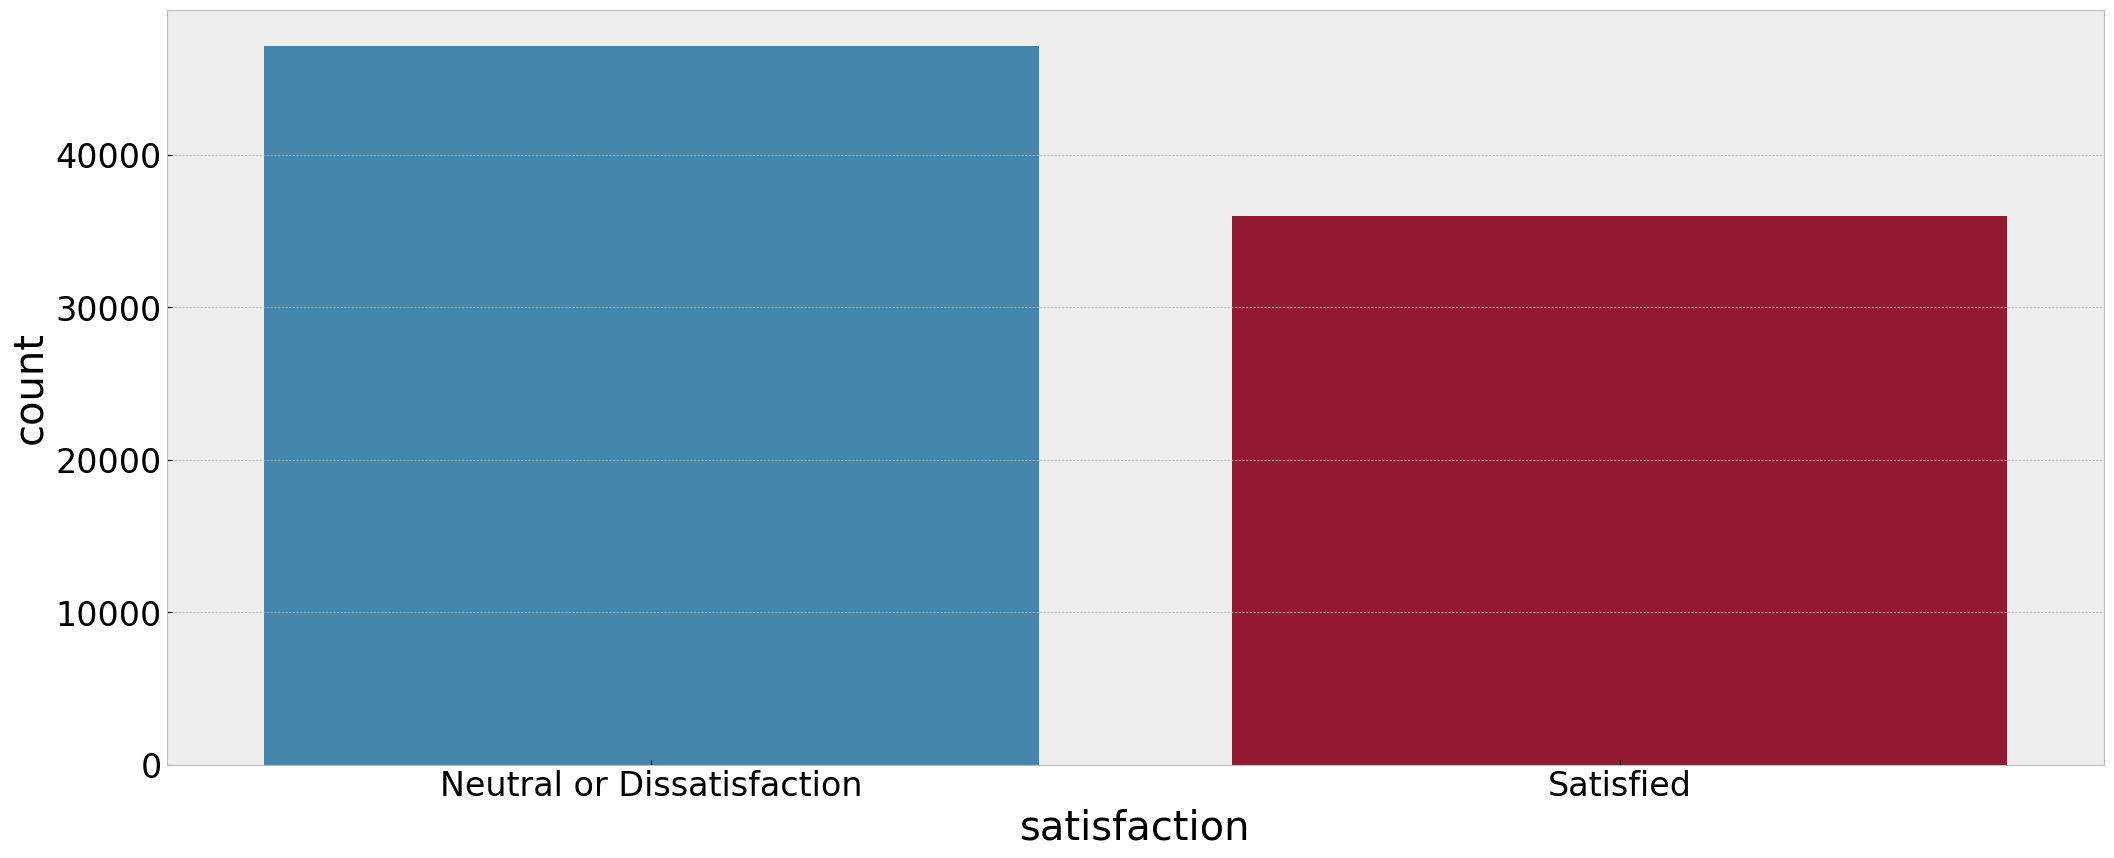

In [23]:
# variavel resposta
sns.countplot( x=df4['satisfaction'] );

Conclusões:

1. 

## 4.2 Analise Bivariada

In [24]:
#InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.
#Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.
import plotly.express as px
cols = ["store_size","instore_wifi"]
df_aux = df4.loc[:,cols].groupby("store_size").mean().reset_index()
fig = px.pie(df_aux, values = "instore_wifi", names ="store_size")
fig



In [25]:
#Self-store:
# poderia ser um painel para auto-atendimento
# Existe alguma relação entre o tamanho da loja e o autoatendimento com a satisfação do cliente

cols = ["store_size","self-store"]
df_aux = df4.loc[:,cols].groupby("store_size").mean().reset_index()
fig = px.bar(df_aux, y = "self-store", x ="store_size")
fig



## 4.3 Analise Multivariada

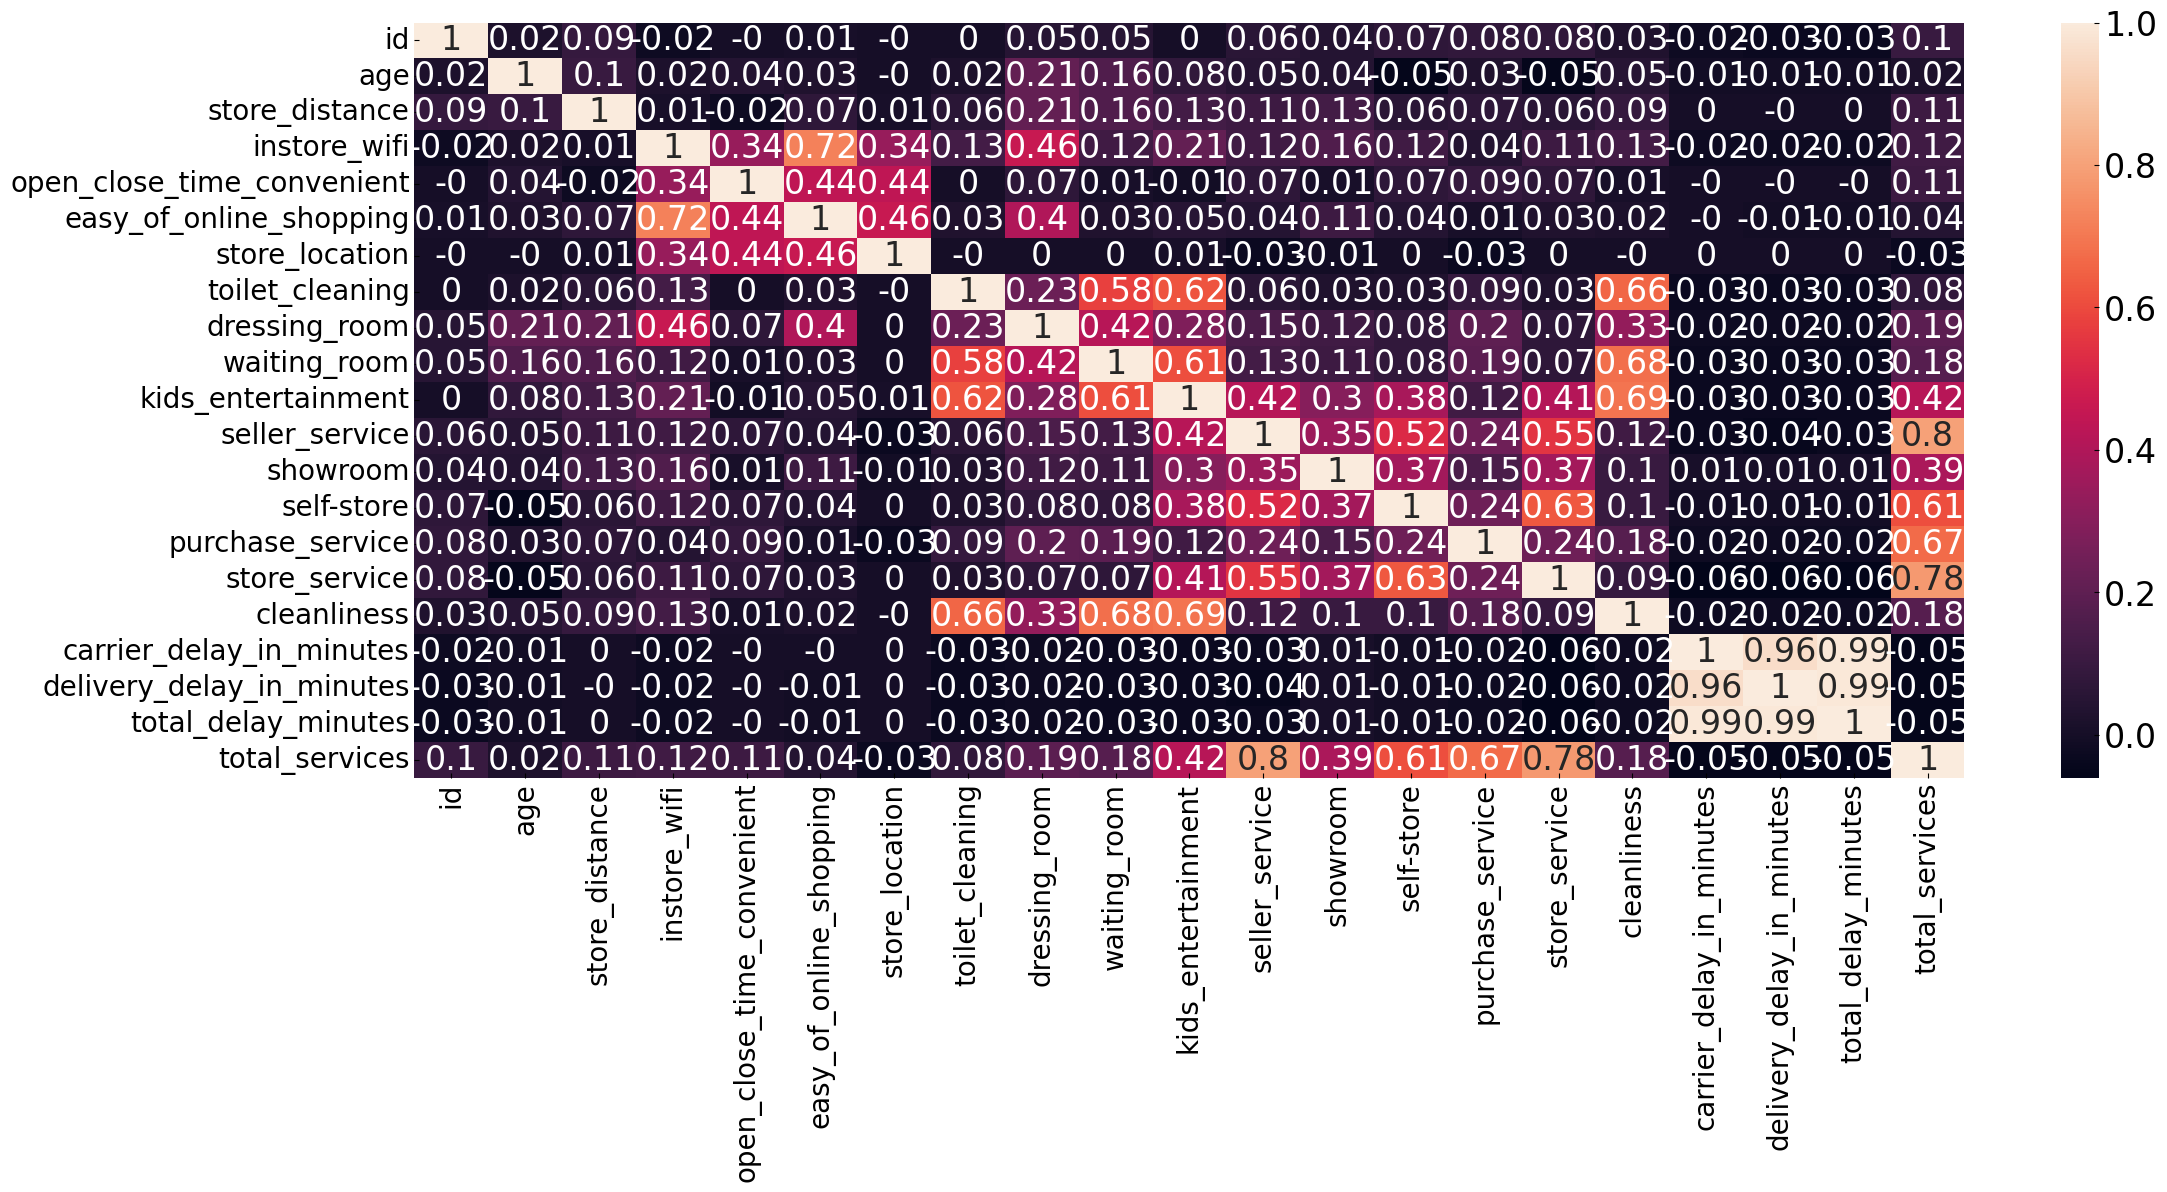

In [26]:
# numerical
num_attributes = df4.select_dtypes(include='number')

correlation = num_attributes.corr( method='pearson' )

sns.heatmap( correlation.round(2), annot=True )

plt.tick_params(axis='both', labelsize=20);

In [27]:
# média das correlação de uma variável numéricas com as demais
correlation.mean(axis=1).sort_values(ascending=False)

kids_entertainment           0.268
total_services               0.267
seller_service               0.223
waiting_room                 0.213
dressing_room                0.212
cleanliness                  0.209
store_service                0.208
self-store                   0.206
instore_wifi                 0.194
showroom                     0.182
toilet_cleaning              0.170
purchase_service             0.169
easy_of_online_shopping      0.166
open_close_time_convenient   0.131
carrier_delay_in_minutes     0.126
total_delay_minutes          0.125
delivery_delay_in_minutes    0.123
store_distance               0.117
store_location               0.103
age                          0.083
id                           0.075
dtype: float64

In [28]:
# # categorical
# def crammer_v(x, y):
#     cm = pd.crosstab(x, y).values

#     chi2 = stats.chi2_contingency(cm)[0]
#     n = cm.sum()
#     r, k = cm.shape

#     chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

#     rcorr = r - (r-1)**2 / (n-1)
#     kcorr = k - (k-1)**2 / (n-1)

#     return np.sqrt( (chi2corr/n) / min(rcorr-1, kcorr-1) )


# cat_attributes = df4.select_dtypes(exclude='number')
# selected_cols = cat_attributes.columns
# cols_permutation = list(product(selected_cols, repeat=2))

# v_values = [ crammer_v( cat_attributes[col1], cat_attributes[col2] ) for col1, col2 in cols_permutation ]

# data = np.array(v_values).reshape(5, 5)


# cramer_correlation = pd.DataFrame(data, columns=selected_cols, index=selected_cols)
# #cramer_correlation

# sns.heatmap(cramer_correlation, annot=True)
# plt.tick_params(axis='both', labelsize=20);

In [29]:
# cramer_correlation['satisfaction']

# 5.0 Preparação dos dados

In [30]:
df5 = df4.copy()

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='delivery_delay_in_minutes'>

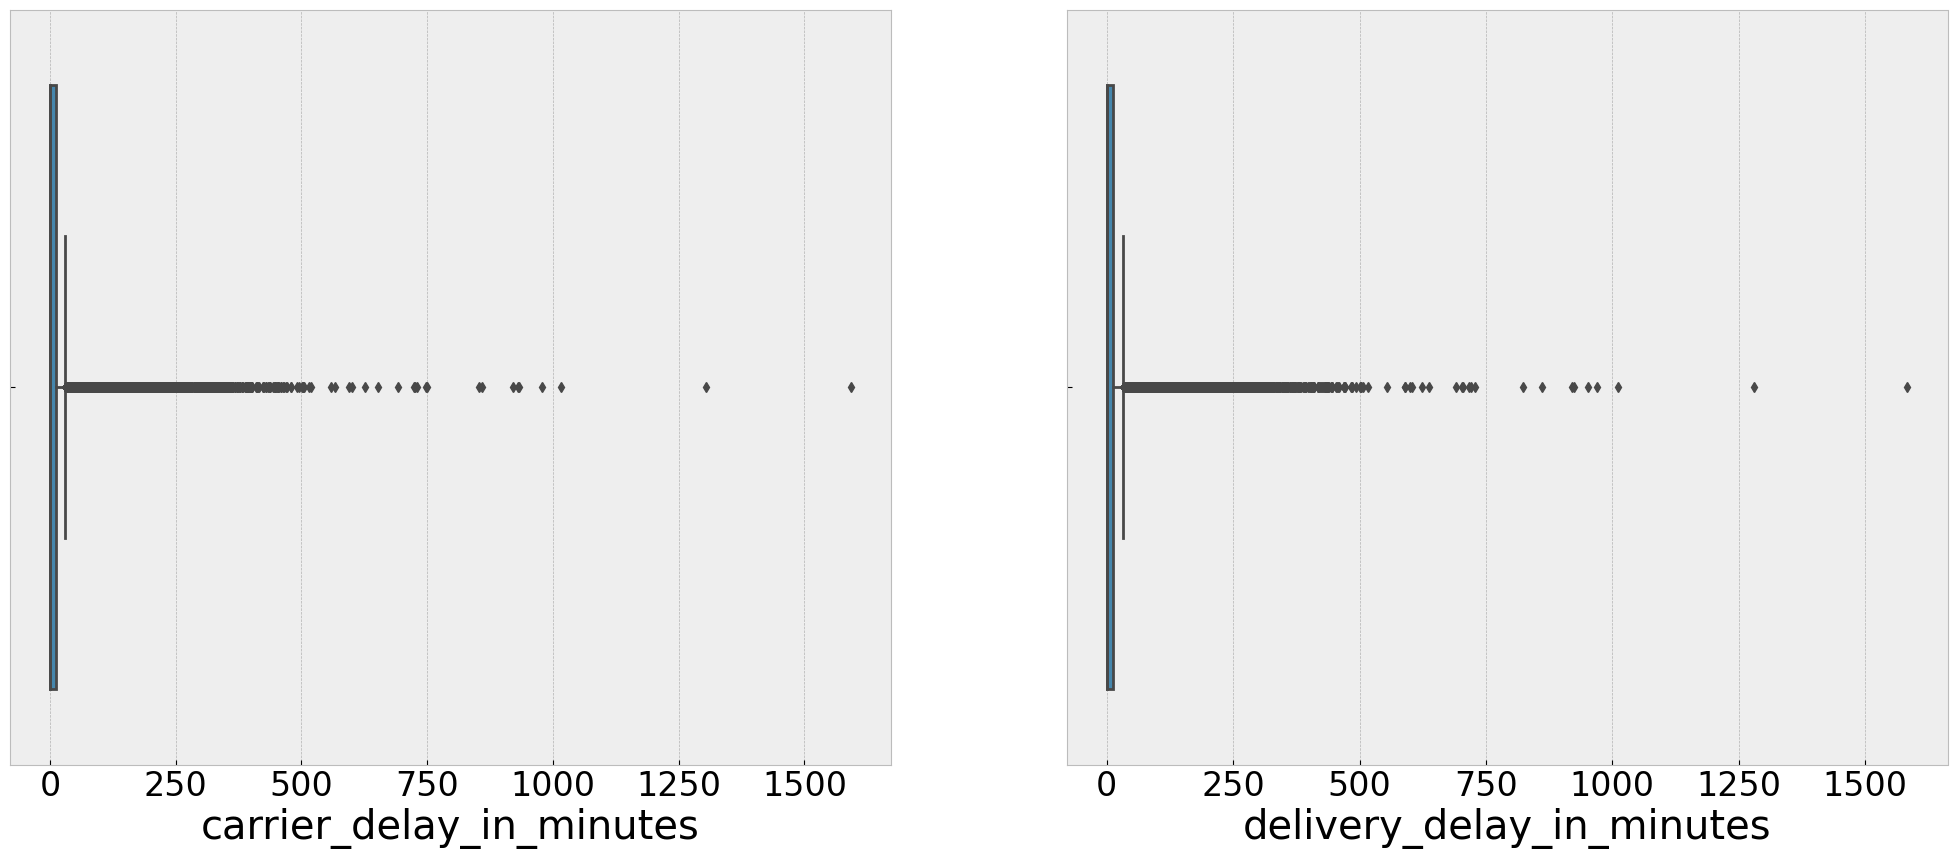

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2)
sns.boxplot( df5['carrier_delay_in_minutes'], ax=axes[0] )
sns.boxplot( df5['delivery_delay_in_minutes'], ax=axes[1] )

## Reescaling

In [32]:
a = df4.select_dtypes(include=['int64','float64'])

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

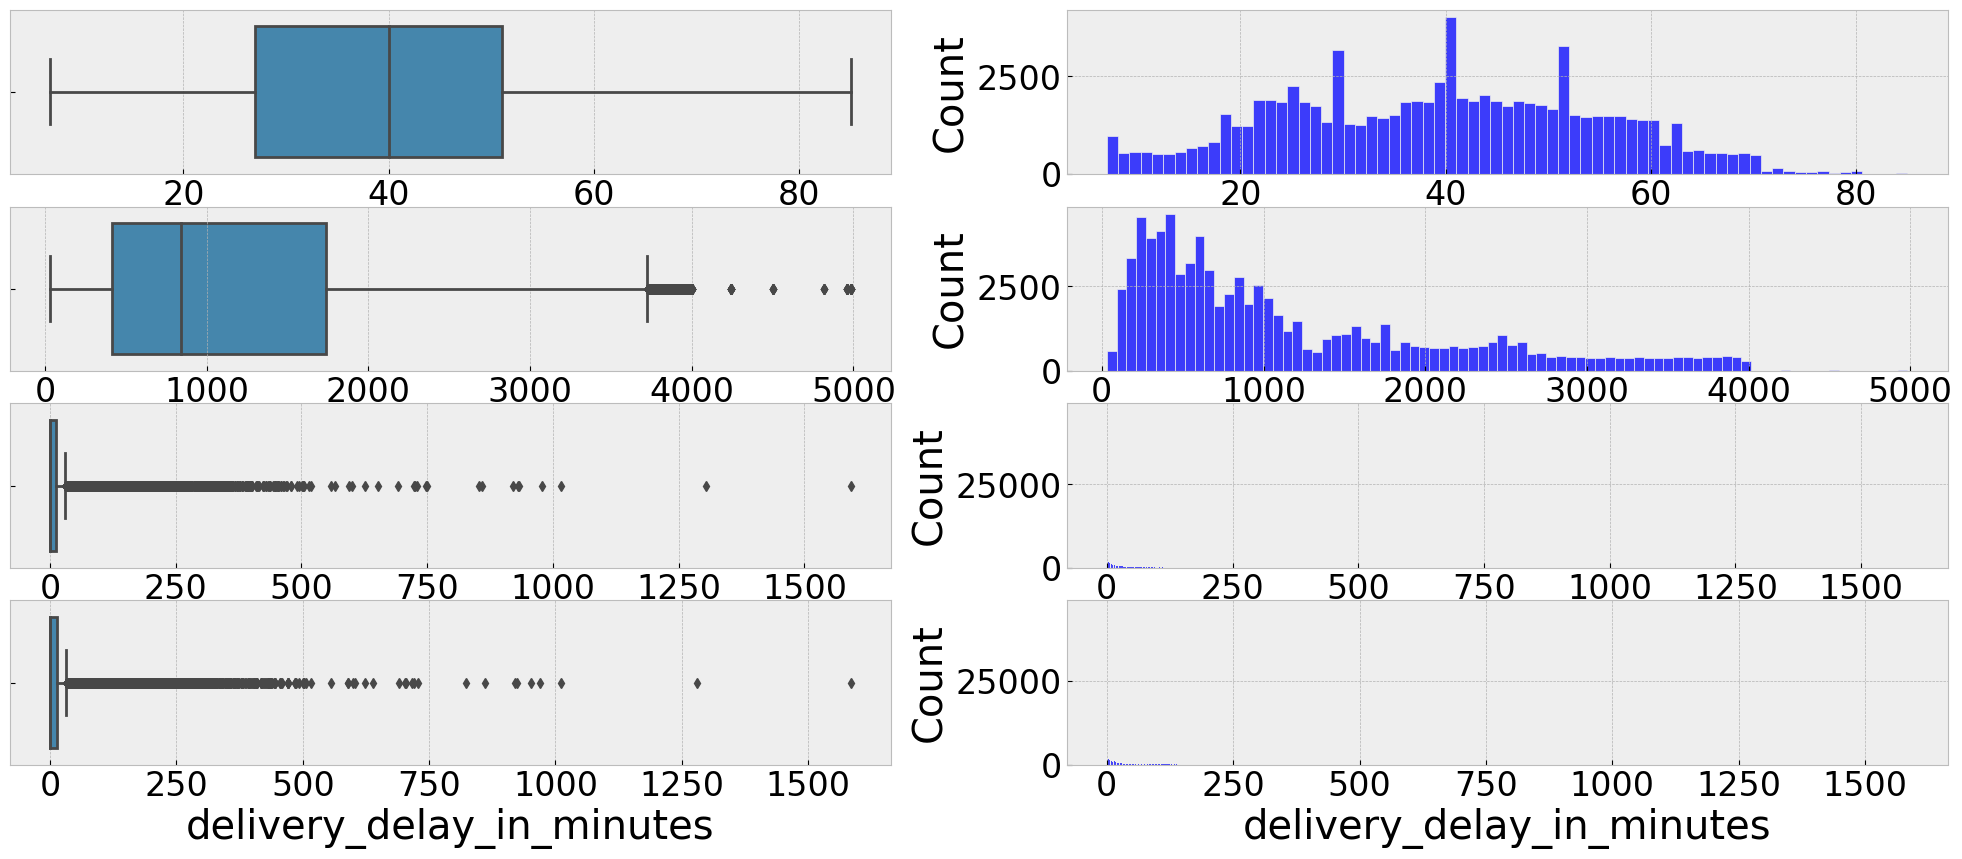

In [33]:
plt.subplot(4,2,1)
sns.boxplot(df5['age'],orient='h');

plt.subplot(4,2,2)
aux00 = df5.loc[:, 'age']
sns.histplot(aux00);

plt.subplot(4,2,3)
sns.boxplot(df5['store_distance'],orient='h');

plt.subplot(4,2,4)
aux00 = df5.loc[:, 'store_distance']
sns.histplot(aux00);

plt.subplot(4,2,5)
sns.boxplot(df5['carrier_delay_in_minutes'],orient='h');

plt.subplot(4,2,6)
aux00 = df5.loc[:, 'carrier_delay_in_minutes']
sns.histplot(aux00);

plt.subplot(4,2,7)
sns.boxplot(df5['delivery_delay_in_minutes'],orient='h');

plt.subplot(4,2,8)
aux00 = df5.loc[:, 'delivery_delay_in_minutes']
sns.histplot(aux00);

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

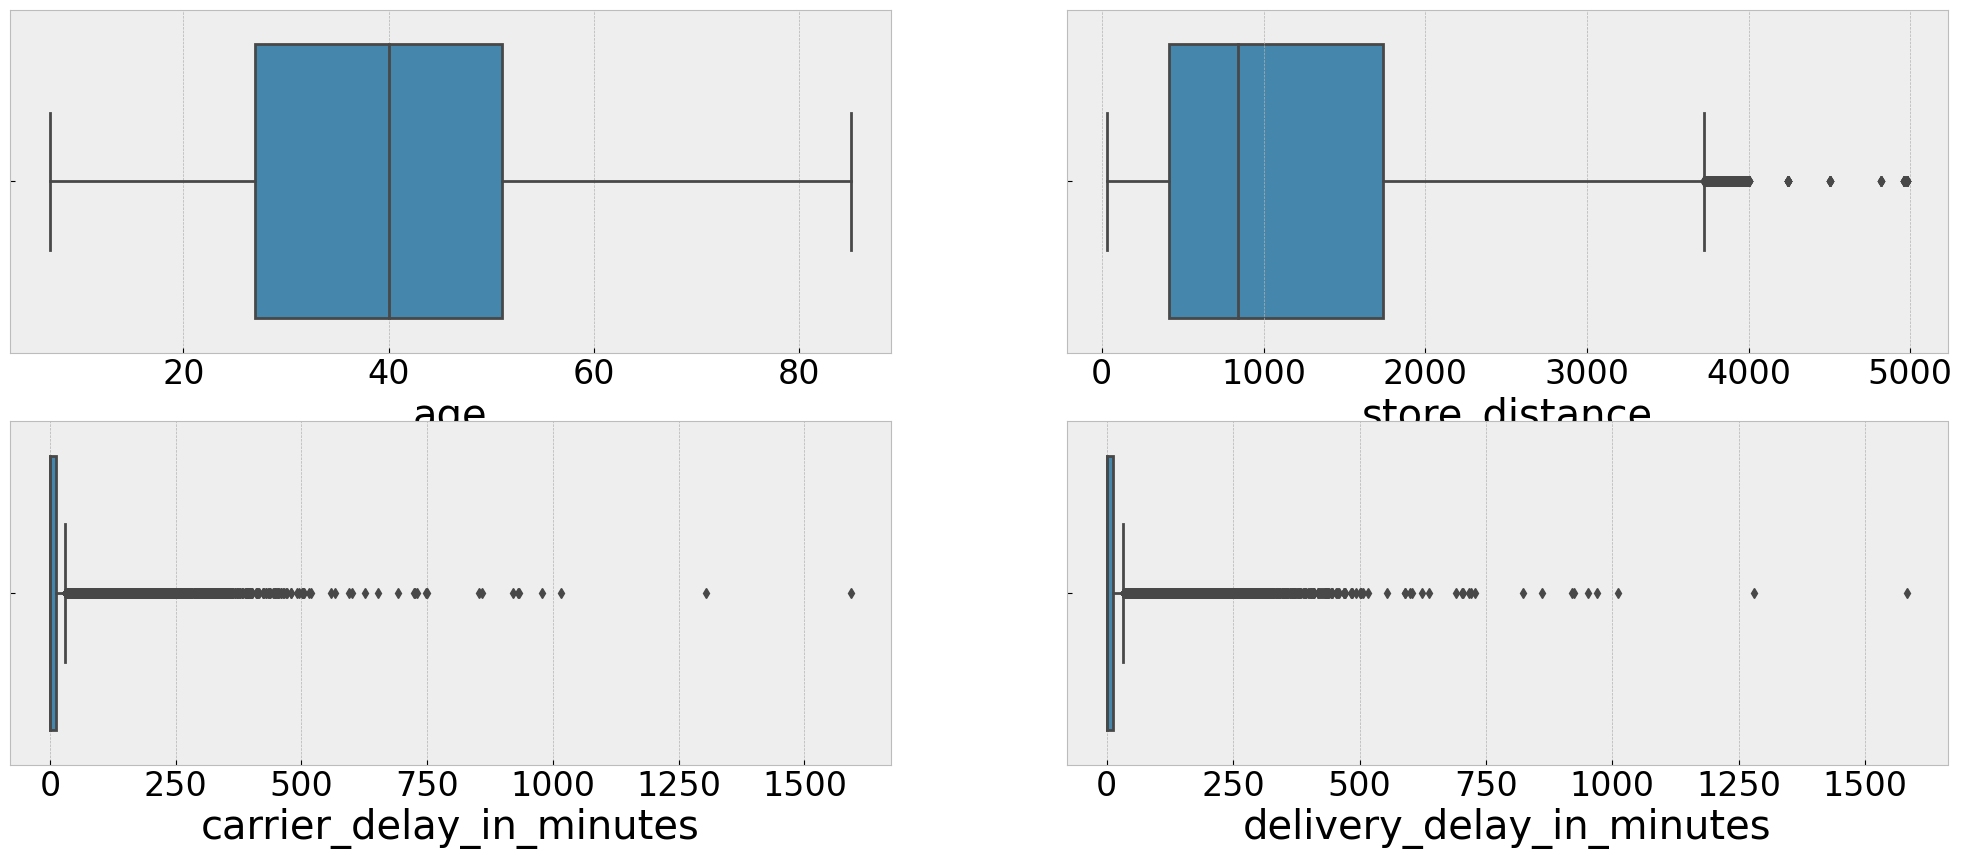

In [34]:
#Verificando se tem outliers

plt.subplot(2,2,1)
sns.boxplot(df5['age'],orient='h');

plt.subplot(2,2,2)
sns.boxplot(df5['store_distance'],orient='h');

plt.subplot(2,2,3)
sns.boxplot(df5['carrier_delay_in_minutes'],orient='h');

plt.subplot(2,2,4)
sns.boxplot(df5['delivery_delay_in_minutes'],orient='h');


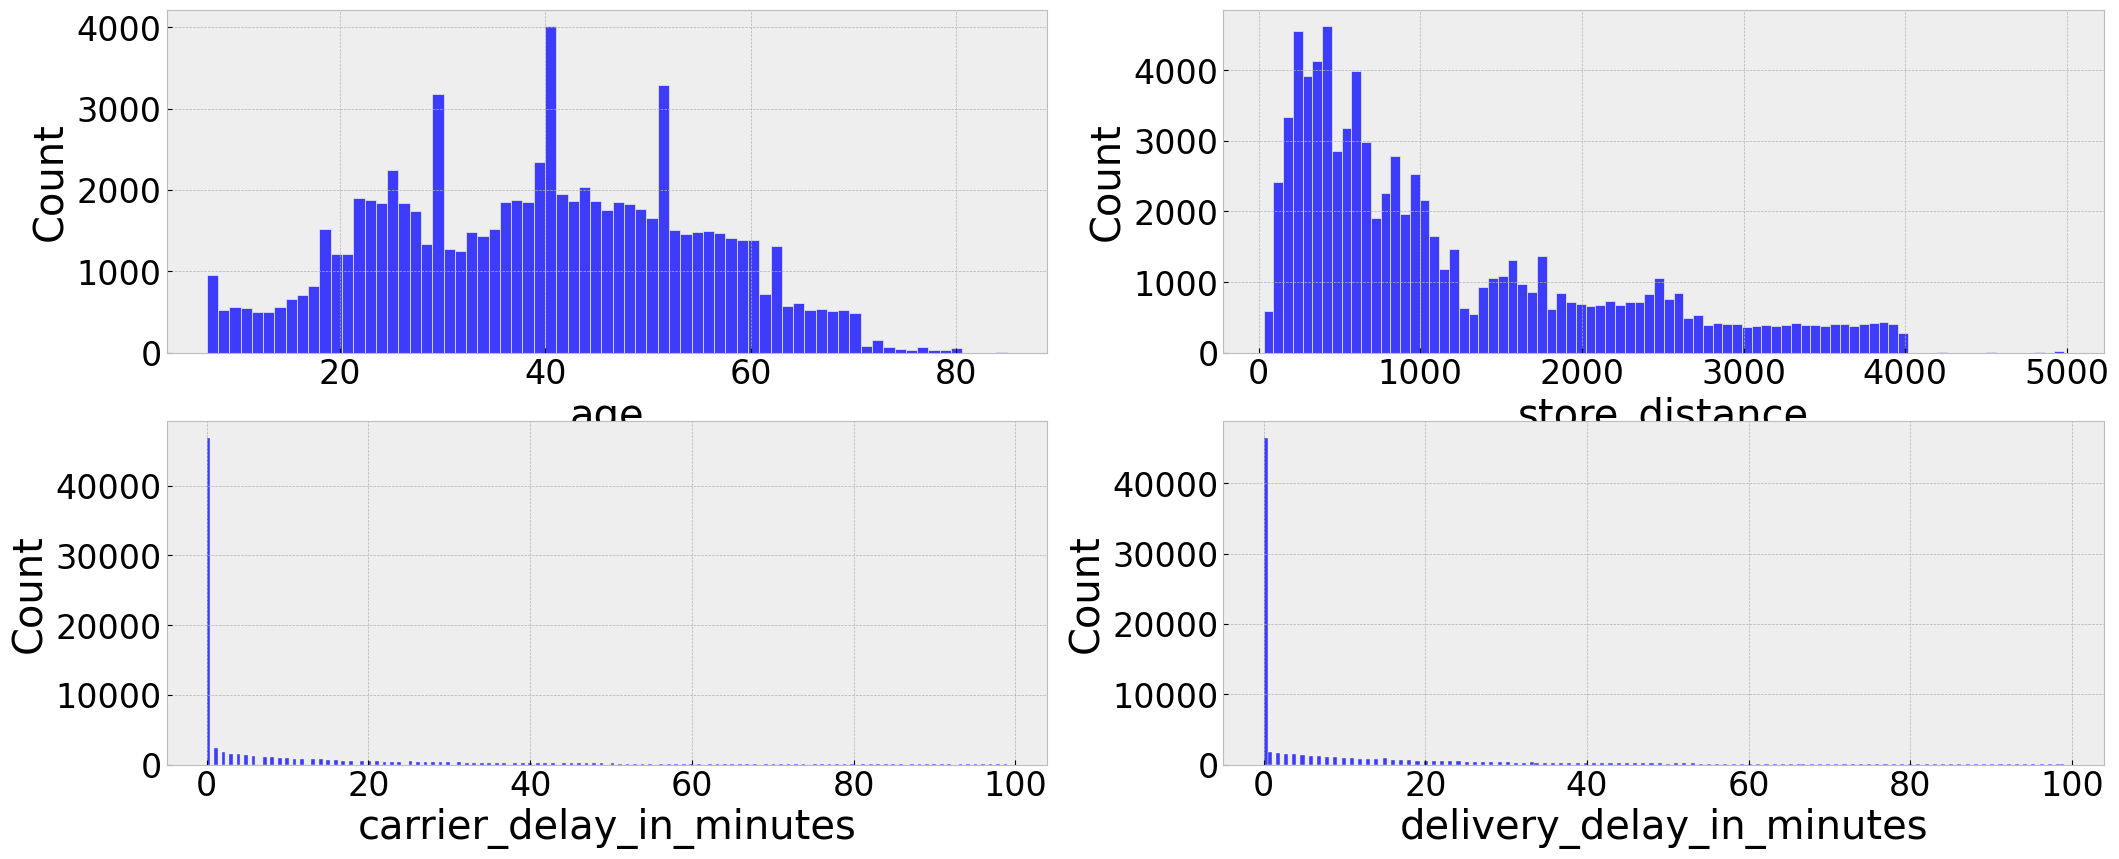

In [35]:
#Verificando a distribuição

plt.subplot(2,2,1)
aux00 = df5.loc[:, 'age']
sns.histplot(aux00); #Distribuição não normal - MMS

plt.subplot(2,2,2)
aux00 = df5.loc[:, 'store_distance']
sns.histplot(aux00);  #Distribuição não normal - MMS

plt.subplot(2,2,3)
aux00 = df5.loc[df5['carrier_delay_in_minutes'] < 100, 'carrier_delay_in_minutes']
sns.histplot(aux00); #Muitos outliers - Robust Scaler

plt.subplot(2,2,4)
aux00 = df5.loc[df5['delivery_delay_in_minutes'] < 100, 'delivery_delay_in_minutes']
sns.histplot(aux00); #Muitos outliers - Robust Scaler

## 5.2 Encoding

In [38]:
# from sklearn.preprocessing import RobustScaler,MinMaxScaler

# rs = RobustScaler()
# mms = MinMaxScaler()
# le = LabelEncoder()

# df5['satisfaction'] = le.fit_transform( df5['satisfaction'] )
# y_val = le.transform( y_val )


# def apply_rescaler(encoder, columns, df_train, df_val, df_test, y_train=None):
#     for col in columns:
#         if y_train is not None:
#             encoded = encoder.fit_transform(df_train[[col]], y_train)
#         else:
#             encoded = encoder.fit_transform(df_train[[col]])
        
#         df_train[col] = encoded
#         df_val[col] = encoder.transform(df_val[[col]])
#         df_test[col] = encoder.transform(df_test[[col]])
    
#     return df_train, df_val, df_test


# def apply_encoder(encoder, columns, df_train, df_val, df_test, y_train=None):
#     for col in columns:
#         if y_train is not None:
#             df_train_encoded = encoder.fit_transform(df_train[[col]], y_train)
#         else:
#             df_train_encoded = encoder.fit_transform(df_train[[col]])

#         df_val_encoded = encoder.transform(df_val[[col]])
#         df_test_encoded = encoder.transform(df_test[[col]])

#         # handle multiple output columns
#         if df_train_encoded.shape[1] > 1:

#             new_col_names = {name: col + "_" + str(idx) for idx, name in enumerate(df_train_encoded.columns)}
#             df_train_encoded = df_train_encoded.rename(columns=new_col_names)
#             df_val_encoded = df_val_encoded.rename(columns=new_col_names)
#             df_test_encoded = df_test_encoded.rename(columns=new_col_names)

#             df_train = pd.concat([df_train.drop(col, axis=1), df_train_encoded], axis=1)
#             df_val = pd.concat([df_val.drop(col, axis=1), df_val_encoded], axis=1)
#             df_test = pd.concat([df_test.drop(col, axis=1), df_test_encoded], axis=1)
#         else:
#             df_train[col] = df_train_encoded.values
#             df_val[col] = df_val_encoded.values
#             df_test[col] = df_test_encoded.values
    
#     return df_train, df_val, df_test


# df5, x_val, test_data = apply_rescaler(mms, columns_to_rescaling, df5, x_val, test_data)

# df5, x_val, test_data = apply_rescaler(rs, col_robust, df5, x_val, test_data)

In [40]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score
from sklearn.ensemble import StackingClassifier
import category_encoders as ce


validation_data = pd.concat([x_val, pd.Series(y_val, name='satisfaction')], axis=1)
full_train = pd.concat([df5, validation_data])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())
])

robust_transformer = Pipeline(steps=[
    ('robust', RobustScaler())
])

columns_to_encode = ['gender', 'customer_type', 'type_of_purchase', 'store_size', 'Distance_Range', 'Long_Delay', 'High_Rated_Dressing_Room', 'Customer_Type_Purchase']

columns_to_rescaling = ['age', 'store_distance', 'instore_wifi', 'open_close_time_convenient', 'easy_of_online_shopping', 
                     'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room', 
                     'kids_entertainment', 'seller_service', 'showroom', 'self-store', 
                     'purchase_service', 'store_service', 'cleanliness', 'total_services']

col_robust = ['carrier_delay_in_minutes', 'delivery_delay_in_minutes', 'total_delay_minutes']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, columns_to_encode),
        ('minmax', minmax_transformer, columns_to_rescaling),
        ('robust', robust_transformer, col_robust)
    ])

models = {
    'knn': nh.KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    'logistic': LogisticRegression(solver='lbfgs', max_iter=100, class_weight='balanced',
                             tol=1e-1, random_state=42, n_jobs=-1),
    'extra_tree': en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1),
    'random_forest': en.RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),
    'xgb': XGBClassifier(random_state=42, n_jobs=-1),
    'lgbm': LGBMClassifier(n_jobs=-1, random_state=42, objective='binary', n_estimators=100),
    'catboost': CatBoostClassifier(n_estimators=100 , random_state=42, verbose=False),
    'mlp': MLPClassifier(n_iter_no_change=10, early_stopping=True, random_state=42),
    'ada': en.AdaBoostClassifier(n_estimators=100, random_state=42)
}

estimators = [(name, model) for name, model in models.items() if name != 'mlp']

stacking = StackingClassifier(estimators=estimators, final_estimator=models['mlp'])

models['stacking'] = stacking

model_scores = {}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', stacking)])

scores = cross_val_score(clf, full_train.drop(columns=['id', 'satisfaction']), full_train['satisfaction'], cv=2, 
                            scoring=make_scorer(precision_score, average='micro'), n_jobs=-1)

model_scores['stacking'] = scores.mean()

model_scores_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Score']).sort_values(by='Score', ascending=False)
model_scores_df

KeyboardInterrupt: 

In [ ]:
model_scores_df.iloc[0].values

array([0.96465969])

In [ ]:
model_scores_df.iloc[0].values

array([0.96405336])

In [ ]:
y_hat_proba

array([0.00356844, 0.00440836, 0.00365704, ..., 0.00391224, 0.98967121,
       0.98893109])

In [ ]:
sadasdsadsa

In [ ]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize


search_space = [
    # RandomForest
    Integer(100, 800, name='rf_n_estimators'),
    Integer(1, 20, name = 'rf_max_depth'),
    Real(0.001, 0.1, 'log-uniform', name = 'rf_learning_rate'),
    Integer(1, 100, name = 'rf_min_child_samples'),
    # XGBClassifier
    Integer(100, 800, name='xgb_n_estimators'),
    Integer(1, 20, name = 'xgb_max_depth'),
    Real(0.001, 0.1, 'log-uniform', name = 'xgb_learning_rate'),
    Integer(1, 100, name = 'xgb_min_child_samples'),
    # ExtraTreesClassifier
    Integer(100, 800, name='et_n_estimators'),
    Integer(1, 20, name = 'et_max_depth'),
    Real(0.001, 0.1, 'log-uniform', name = 'et_learning_rate'),
    Integer(1, 100, name = 'et_min_child_samples'),
    # LGBMClassifier
    Integer(100, 800, name='lgbm_n_estimators'),
    Integer(1, 20, name = 'lgbm_max_depth'),
    Real(0.001, 0.1, 'log-uniform', name = 'lgbm_learning_rate'),
    Integer(1, 100, name = 'lgbm_min_child_samples'),
    # KNeighborsClassifier
    Integer(1, 20, name='knn_n_neighbors'),
    # AdaBoostClassifier
    Integer(100, 800, name='ada_n_estimators'),
    Integer(1, 20, name = 'ada_max_depth'),
    Real(0.001, 0.1, 'log-uniform', name = 'ada_learning_rate'),
    Integer(1, 100, name = 'ada_min_child_samples'),
]

@use_named_args(search_space)
def objective(**params):
    models_optimized = {
        'knn': nh.KNeighborsClassifier(n_neighbors=params['knn_n_neighbors'], n_jobs=-1),
        'logistic': LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced',
                                 tol=1e-1, random_state=42, n_jobs=-1),
        'extra_tree': en.ExtraTreesClassifier(n_estimators=params['et_n_estimators'], max_depth=params['et_max_depth'], random_state=0, n_jobs=-1),
        'random_forest': en.RandomForestClassifier(n_estimators=params['rf_n_estimators'], max_depth=params['rf_max_depth'], random_state=0, n_jobs=-1),
        'xgb': XGBClassifier(n_estimators=params['xgb_n_estimators'], max_depth=params['xgb_max_depth'], learning_rate=params['xgb_learning_rate'], min_child_samples=params['xgb_min_child_samples'], random_state=42, n_jobs=-1),
        'lgbm': LGBMClassifier(n_estimators=params['lgbm_n_estimators'], max_depth=params['lgbm_max_depth'], learning_rate=params['lgbm_learning_rate'], min_child_samples=params['lgbm_min_child_samples'], random_state=42, n_jobs=-1),
        'catboost': CatBoostClassifier(random_state=42, verbose=False),
        'mlp': MLPClassifier(n_iter_no_change=10, early_stopping=True, random_state=42),
        'ada': en.AdaBoostClassifier(n_estimators=params['ada_n_estimators'], learning_rate=params['ada_learning_rate'], random_state=42)
    }

    estimators_optimized = [(name, model) for name, model in models_optimized.items() if name != 'mlp']

    stacking_optimized = StackingClassifier(estimators=estimators_optimized, final_estimator=models['mlp'])

    clf_optimized = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', stacking_optimized)])

    scores = cross_val_score(clf_optimized, full_train.drop(columns=['id', 'satisfaction']), full_train['satisfaction'], cv=2, 
                            scoring=make_scorer(precision_score, average='micro'), n_jobs=-1)

    return -scores.mean()

result = gp_minimize(objective, search_space, n_calls=50, n_initial_points=10, verbose=True, n_jobs=-1, random_state=42)

print("Melhor pontuação: ", -result.fun)
print("Melhores parâmetros: ", result.x)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 368.8662
Function value obtained: -0.9650
Current minimum: -0.9650
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 689.3479
Function value obtained: -0.9653
Current minimum: -0.9653
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 749.3941
Function value obtained: -0.9647
Current minimum: -0.9653
Iteration No: 4 started. Evaluating function at random point.


0.96534301

In [ ]:
sadasdas

In [ ]:
# import category_encoders as ce

# from sklearn.pipeline import Pipeline

# # Definindo os pipelines para cada modelo
# knn_pipeline = Pipeline(steps=[
#     ('encoder', ce.HashingEncoder()),
#     ('model', models['xgb'])
# ])

# rf_pipeline = Pipeline(steps=[
#     ('encoder', ce.SumEncoder()),
#     ('model', models['lgbm'])
# ])


# # Definindo os estimadores para o stacking
# estimators = [('knn', knn_pipeline), ('random_forest', rf_pipeline)]

# # Criando o modelo de stacking
# stacking = StackingClassifier(estimators=estimators, final_estimator=models['mlp'])

# # Avaliando o modelo de stacking com cross-validation
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('classifier', stacking)])

# scores = cross_val_score(clf, full_train.drop(columns=['id', 'satisfaction']), full_train['satisfaction'], cv=5, 
#                             scoring=make_scorer(precision_score, average='micro'), n_jobs=-1)

# model_scores = {'stacking': scores.mean()}
# model_scores_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Score']).sort_values(by='Score', ascending=False)
# model_scores_df

,Score
stacking,0.964


In [41]:
from mlens.ensemble import SuperLearner
from sklearn.base import BaseEstimator, ClassifierMixin

le = LabelEncoder()

class SklearnSuperLearner(BaseEstimator, ClassifierMixin):

    def __init__(self, base_learners, meta_learner, preprocessor):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.preprocessor = preprocessor
        self.sl = SuperLearner()

    def fit(self, X, y):
        X_processed = self.preprocessor.fit_transform(X)
        X_processed = pd.DataFrame(X_processed, columns=X.columns)
        self.sl.add(self.base_learners)
        self.sl.add_meta(self.meta_learner)
        self.sl.fit(X_processed, y)
        return self

    def predict(self, X):
        X_processed = self.preprocessor.transform(X)
        X_processed = pd.DataFrame(X_processed, columns=X.columns)
        return self.sl.predict(X_processed)

validation_data = pd.concat([x_val, pd.Series(y_val, name='satisfaction')], axis=1)
full_train = pd.concat([df5, validation_data])

full_train['satisfaction'] = le.fit_transform(full_train['satisfaction'] )

base_learners = [model for name, model in models.items() if name != 'mlp']
meta_learner = models['mlp']

super_learner = SklearnSuperLearner(base_learners, meta_learner, preprocessor)

scores = cross_val_score(super_learner, full_train.drop(columns=['id', 'satisfaction']), full_train['satisfaction'], cv=5, 
                         scoring=make_scorer(precision_score, average='micro'))

print(scores.mean())

[MLENS] backend: threading
f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing

0.964929163425223


In [ ]:
le = LabelEncoder()

# Treine o modelo
clf.fit(df5.drop(columns=['id', 'satisfaction']), df5['satisfaction'])

# # Calcule as probabilidades das previsões
# y_hat_proba = clf.predict_proba(x_val)[:, 1]

# # Calcule precisão e recall para vários thresholds
# precision, recall, thresholds = precision_recall_curve(le.fit_transform(y_val), y_hat_proba)

# best_threshold = 0.5
# best_precision = 0

# # Ajuste o threshold para maximizar a precisão
# for th in thresholds:
#     y_hat_adjusted = (y_hat_proba >= th).astype(int)
#     adjusted_precision = precision_score(le.fit_transform(y_val), y_hat_adjusted, average='micro')
    
#     if adjusted_precision > best_precision:
#         best_threshold = th
#         best_precision = adjusted_precision

# print("Best threshold:", best_threshold)
# print("Best precision:", best_precision)

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:30:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:31:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:18] WARNING:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'customer_type',
                                                   'type_of_purchase',
                                                   'store_size',
                                                   'Distance_Range',
                                                   'Long_Delay',
                                                   'High_Rated_Dressing_Room',
                                                   'Customer_Type_Purchase']),
                                                 ('minmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['age', 'store_distance',
                                                   'instore_wif...
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None)),
                                                ('lgbm',
                                                 LGBMClassifier(random_state=42)),
                                                ('catboost',
                                                 <catboost.core.CatBoostClassifier object at 0x000001C8C52A1790>),
                                                ('ada',
                                                 AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42))],
                                    final_estimator=MLPClassifier(early_stopping=True,
                                                                  random_state=42)))])

In [ ]:
# le = LabelEncoder()

# validation_data = pd.concat([x_val, pd.Series(y_val, name='satisfaction')], axis=1)
# full_train = pd.concat([df5, validation_data])
# full_train['satisfaction'] = le.fit_transform(full_train['satisfaction'])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', stacking)])

# clf.fit(full_train.drop(columns=['id', 'satisfaction']), full_train['satisfaction'])

x_test = test_data.drop(columns=['id']).copy()

y_hat_proba_test = clf.predict_proba(x_test)[:, 1]

y_hat_test_adjusted = (y_hat_proba_test >= best_threshold).astype(int)

final_test = pd.concat([test_data, pd.Series(y_hat_test_adjusted, name='Satisfaction')], axis=1)

final_test[['id', 'Satisfaction']].to_csv('work/submission12.csv', index=False)

In [ ]:
# import category_encoders as ce

# encoders = [
#     ('LabelEncoder', LabelEncoder()),
#     ('BaseNEncoder', ce.BaseNEncoder( )),
#     ('BinaryEncoder', ce.BinaryEncoder( )),
#     ('HashingEncoder', ce.HashingEncoder( )),
#     ('BackwardDifferenceEncoder', ce.BackwardDifferenceEncoder()),
#     ('CatBoostEncoder', ce.CatBoostEncoder( )),
#     ('CountEncoder', ce.CountEncoder(handle_unknown='value', handle_missing='value')),
#     ('GLMMEncoder', ce.GLMMEncoder(handle_unknown='value', handle_missing='value')),
#     ('HelmertEncoder', ce.HelmertEncoder( )),
#     ('JamesSteinEncoder', ce.JamesSteinEncoder( )),
#     ('LeaveOneOutEncoder', ce.LeaveOneOutEncoder( )),
#     ('MEstimateEncoder', ce.MEstimateEncoder( )),
#     ('PolynomialEncoder', ce.PolynomialEncoder( )),
#     ('QuantileEncoder', ce.QuantileEncoder( )),
#     ('SumEncoder', ce.SumEncoder( )),
#     ('WOEEncoder', ce.WOEEncoder( )),
# ]

# encoders_needing_y = ['CatBoostEncoder', 'CountEncoder', 'GLMMEncoder', 'HashingEncoder',
#                       'HelmertEncoder', 'JamesSteinEncoder', 'LeaveOneOutEncoder', 
#                       'MEstimateEncoder', 'PolynomialEncoder', 'QuantileEncoder', 
#                       'SumEncoder', 'WOEEncoder']

# all_metrics = pd.DataFrame(columns=['Encoder', 'Model', 'Precision'])

# for encoder_name, encoder in encoders:
#     train_encod = df5.copy()
#     x_val_encod = x_val.copy()
#     test_encod = test_data.copy()
    
#     print(f"Aplicando {encoder_name}")
    
#     if encoder_name in encoders_needing_y:
#         df_train_encoded, df_val_encoded, df_test_encoded = apply_encoder(encoder, columns_to_encode, train_encod, x_val_encod, test_encod, y_train)
#     elif 'LabelEncoder' in encoder_name:
#         df_train_encoded, df_val_encoded, df_test_encoded = apply_rescaler(encoder, columns_to_encode, train_encod, x_val_encod, test_encod)
#     else:
#         df_train_encoded, df_val_encoded, df_test_encoded = apply_encoder(encoder, columns_to_encode, train_encod, x_val_encod, test_encod)

#     # treinamento e avaliação
#     df6 = df_train_encoded.copy()
#     df7 = df6.drop(columns=['id', 'satisfaction']).copy()
#     y_train = df6['satisfaction'].copy()
#     X_val = df_val_encoded.drop(columns=['id'])

#     knn_model = nh.KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
#     knn_model.fit(df7, y_train)
#     y_hat_knn = knn_model.predict(X_val)
#     knn_precision = precision_score(y_val, y_hat_knn, average='micro')

#     lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced',
#                              tol=1e-1, random_state=42, n_jobs=-1)
#     lr_model.fit(df7, y_train)
#     y_hat_lr = lr_model.predict(X_val)
#     lr_precision = precision_score(y_val, y_hat_lr, average='micro')

#     extra_model = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)
#     extra_model.fit(df7, y_train)
#     y_hat_et = extra_model.predict(X_val)
#     et_precision = precision_score(y_val, y_hat_et, average='micro')

#     rf_model = en.RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
#     rf_model.fit(df7, y_train)
#     y_hat_rf = rf_model.predict(X_val)
#     rf_precision = precision_score(y_val, y_hat_rf, average='micro')

#     xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
#     xgb_model.fit(df7, y_train)
#     y_hat_xgb = xgb_model.predict(X_val)
#     xgb_precision = precision_score(y_val, y_hat_xgb, average='micro')

#     lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)
#     lgbm_model.fit(df7, y_train)
#     y_hat_lgbm = lgbm_model.predict(X_val)
#     lgbm_precision = precision_score(y_val, y_hat_lgbm, average='micro')

#     cat_model = CatBoostClassifier(random_state=42, verbose=False)
#     cat_model.fit(df7, y_train)
#     y_hat_cat = cat_model.predict(X_val)
#     cat_precision = precision_score(y_val, y_hat_cat, average='micro')

#     mlp_model = MLPClassifier(n_iter_no_change=10, early_stopping=True, random_state=42)
#     mlp_model.fit(df7, y_train)
#     y_hat_mlp = mlp_model.predict(X_val)
#     mlp_precision = precision_score(y_val, y_hat_mlp, average='micro')

#     ada_model = en.AdaBoostClassifier(n_estimators=100, random_state=42)
#     ada_model.fit(df7, y_train)
#     y_hat_ada = ada_model.predict(X_val)
#     ada_precision = precision_score(y_val, y_hat_ada, average='micro')

#     precision_dict = {'knn': knn_precision,
#                 'logistic': lr_precision,
#                 'extra_tree': et_precision,
#                 'random_forest': rf_precision,
#                 'xgb': xgb_precision,
#                 'lgbm': lgbm_precision,
#                 'catboost': cat_precision,
#                 'mlp': mlp_precision,
#                 'ada': ada_precision,
#                   }

#     for model_name, precision in precision_dict.items():
#         all_metrics = all_metrics.append({'Encoder': encoder_name, 'Model': model_name, 'Precision': precision}, ignore_index=True)

# all_metrics = all_metrics.sort_values('Precision', ascending=False)

In [ ]:
all_metrics.groupby(['Encoder'], as_index=False).sum().sort_values('Precision', ascending=False)

,Encoder,Precision
5,GLMMEncoder,8.456
15,WOEEncoder,8.454
1,BaseNEncoder,8.452
2,BinaryEncoder,8.452
14,SumEncoder,8.452
7,HelmertEncoder,8.449
12,PolynomialEncoder,8.448
6,HashingEncoder,8.447
9,LabelEncoder,8.444
0,BackwardDifferenceEncoder,8.442


In [ ]:
# df5, x_val, test_data = apply_encoder(ce.GLMMEncoder(handle_unknown='value', handle_missing='value'), columns_to_encode, df5, x_val, test_data, y_train)

In [ ]:
test_data.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,total_delay_minutes
0,19556,Female,Loyal Customer,0.500,Gift,Medium,-0.515,1.000,0.500,0.000,...,0.500,0.500,0.500,0.500,-1.000,0.500,1.000,50,44,94
1,90035,Female,Loyal Customer,-0.167,Gift,Large,1.525,-1.000,-1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0,0,0
2,12360,Male,disloyal Customer,-0.833,Gift,Medium,-0.491,-0.500,-1.500,-0.500,...,-1.000,0.000,-1.500,-0.500,-1.000,-1.000,-0.500,0,0,0
3,77959,Male,Loyal Customer,0.167,Gift,Large,1.913,-1.500,-1.500,-1.500,...,-1.500,-1.500,-1.500,-1.500,0.000,-1.500,0.500,0,6,6
4,36875,Female,Loyal Customer,0.375,Gift,Medium,0.257,-0.500,0.000,0.500,...,-1.000,-1.000,-1.000,-1.000,1.000,-1.000,0.500,0,20,20


# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()
#data preparation
x_train_n = df6.drop(['id','satisfaction'],axis=1)
y_train_n = y_train.values

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators = 100)

sel = SelectFromModel( rf )

sel.fit(x_train_n, y_train_n)

SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
selected_feat = x_train_n.columns[ (sel.get_support()) ]
selected_feat

Index(['type_of_purchase', 'store_size', 'instore_wifi', 'dressing_room',
       'waiting_room', 'kids_entertainment'],
      dtype='object')

In [ ]:
rf.fit(x_train_n, y_train_n)

rf.feature_importances_

array([0.00478861, 0.03445397, 0.032539  , 0.09746343, 0.09624402,
       0.04111091, 0.13189862, 0.0155898 , 0.04024103, 0.01603732,
       0.01195229, 0.18328102, 0.04155939, 0.05758779, 0.03004445,
       0.03718242, 0.0252808 , 0.02377703, 0.02248048, 0.02493308,
       0.00944334, 0.01058626, 0.01152493])

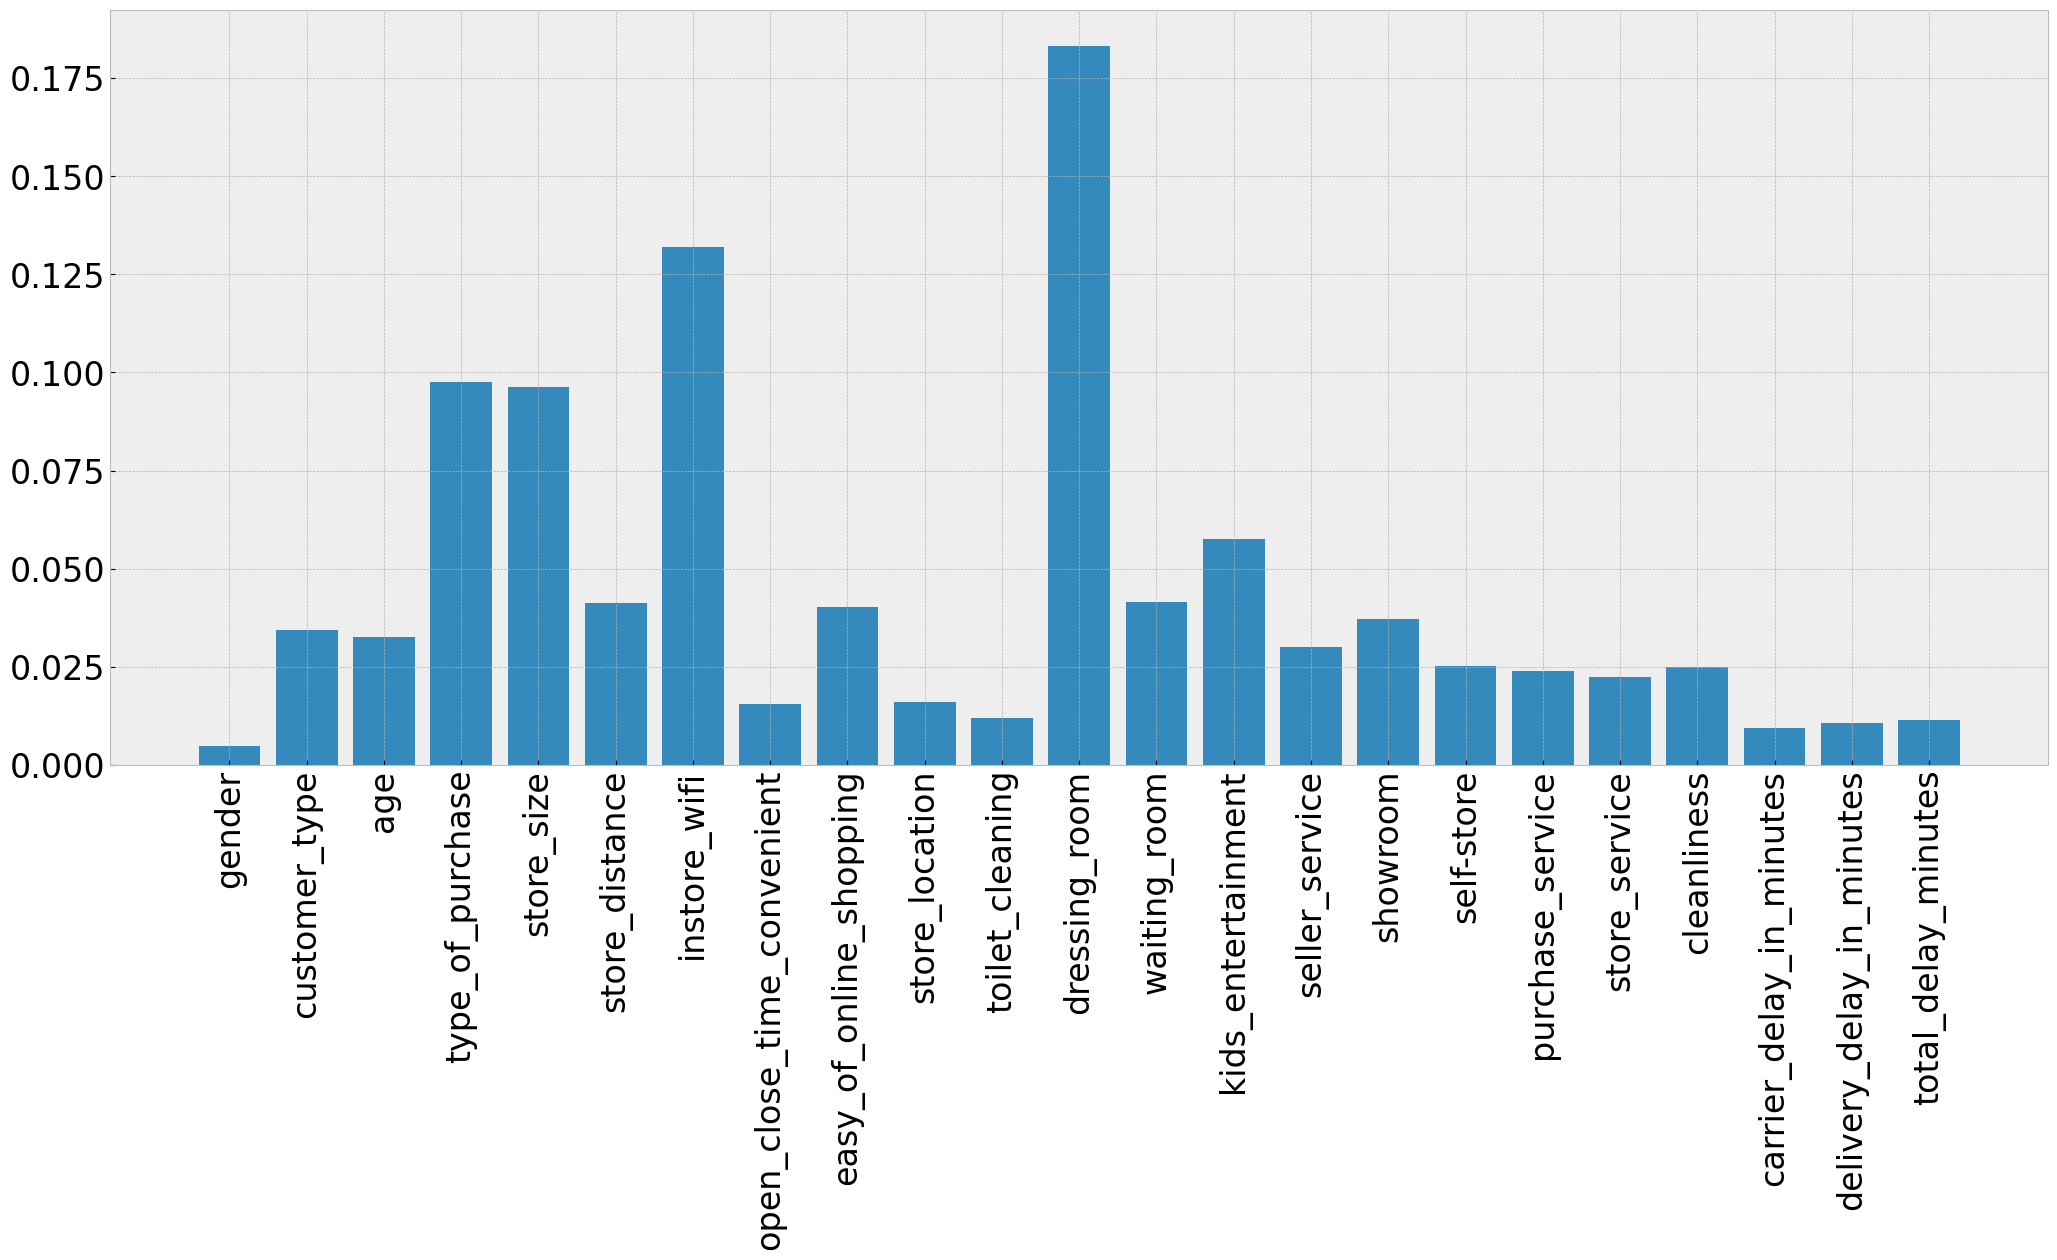

In [ ]:
features = x_train_n.columns

plt.bar( features, rf.feature_importances_ )
plt.xticks( rotation=90 );

- dressing_room 

- instore_wifi

- type_of_purchase

- store_size

Feature Ranking
                      feature  importance
0                  store_size       0.131
0                instore_wifi       0.131
0            type_of_purchase       0.121
0               dressing_room       0.105
0          kids_entertainment       0.056
0               customer_type       0.054
0                waiting_room       0.043
0     easy_of_online_shopping       0.042
0              seller_service       0.037
0                 cleanliness       0.032
0                    showroom       0.032
0                  self-store       0.030
0            purchase_service       0.030
0               store_service       0.028
0              store_distance       0.023
0                         age       0.021
0  open_close_time_convenient       0.018
0              store_location       0.018
0             toilet_cleaning       0.014
0         total_delay_minutes       0.011
0   delivery_delay_in_minutes       0.010
0    carrier_delay_in_minutes       0.009
0                 

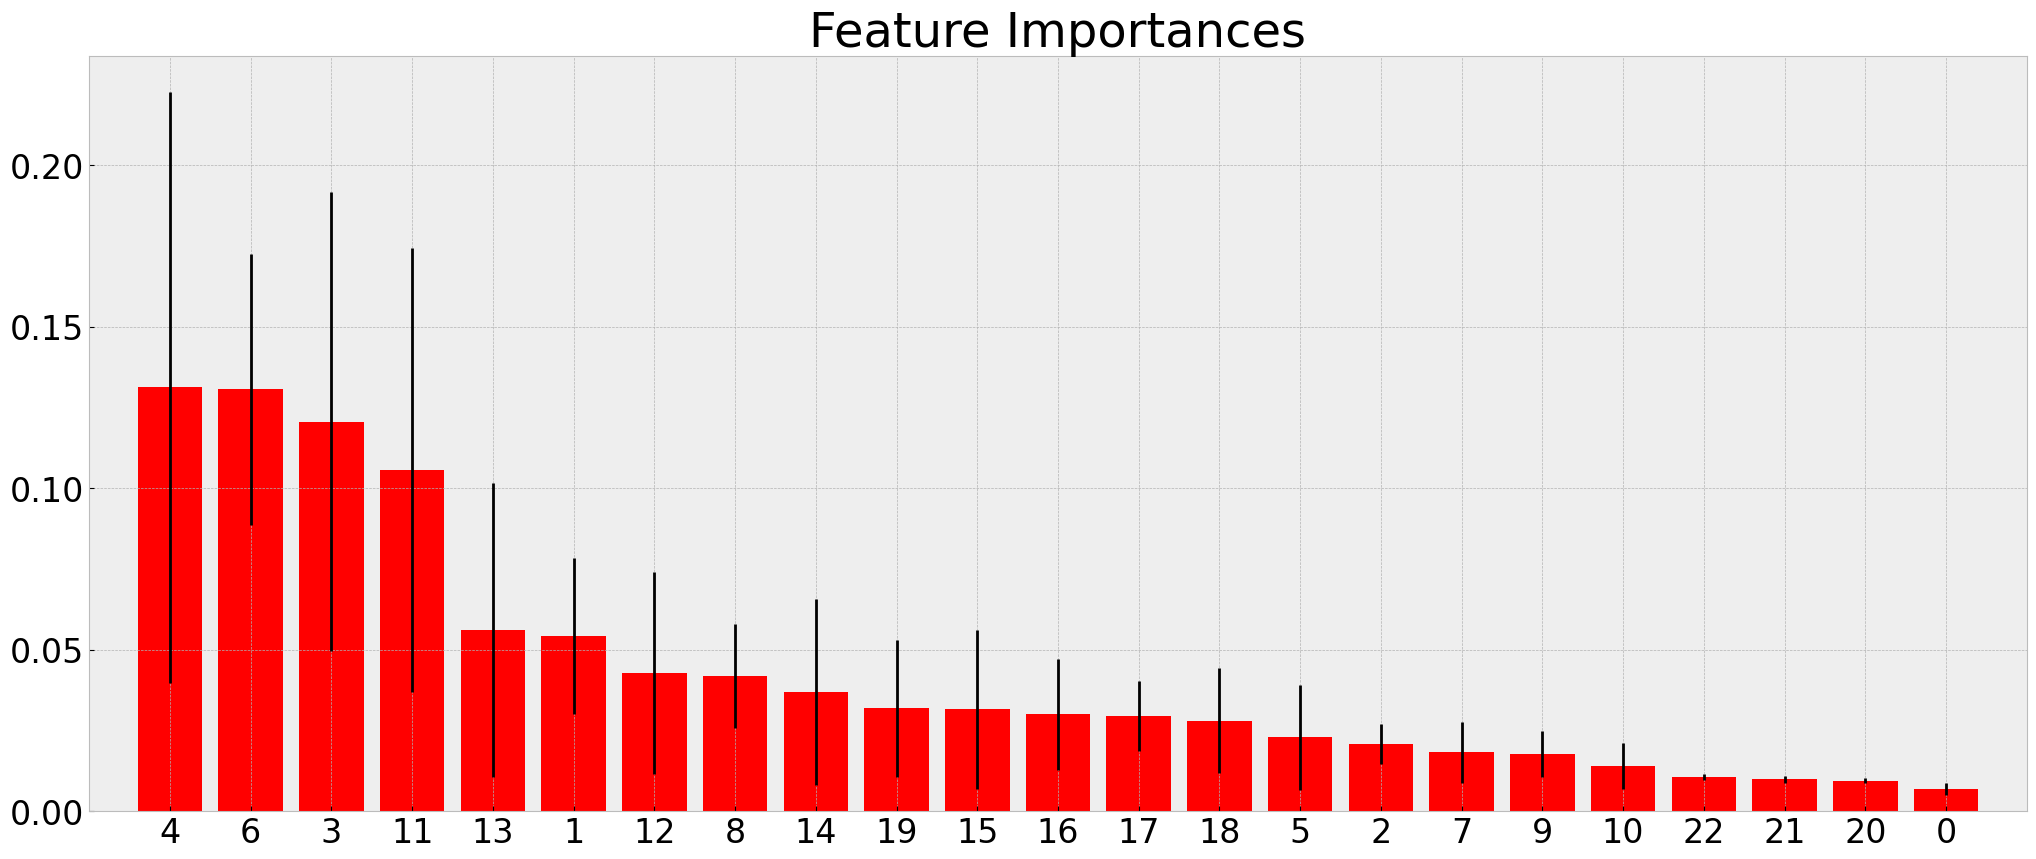

In [ ]:
#Teste de Feature Selection

#model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0,n_jobs=-1)

forest.fit(x_train_n,y_train_n)

importances = forest.feature_importances_ #Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1] #Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

- type_of_purchase

- dressing_room

- instore_wifi

## Boruta

In [ ]:
X_train_n_boruta = df6.drop(['id','satisfaction'],axis=1).values
Y_train_n_boruta = y_train.values.ravel()

In [ ]:
from boruta                import BorutaPy

#Definindo os datasets para o Boruta
#X_train_n = X_train.drop(['date','sales'],axis=1).values
#Y_train_n = Y_train.values.ravel()

#Definindo o RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Definindo o Boruta
boruta = BorutaPy(forest,n_estimators='auto',verbose=2,random_state=42,max_iter=10).fit(X_train_n_boruta,Y_train_n_boruta)

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	19
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 10
Confirmed: 	19
Tentative: 	0
Rejected: 	4


In [ ]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x_train_n.iloc[:,cols_selected].columns.to_list()
cols_selected_boruta

['customer_type',
 'age',
 'type_of_purchase',
 'store_size',
 'store_distance',
 'instore_wifi',
 'open_close_time_convenient',
 'easy_of_online_shopping',
 'store_location',
 'toilet_cleaning',
 'dressing_room',
 'waiting_room',
 'kids_entertainment',
 'seller_service',
 'showroom',
 'self-store',
 'purchase_service',
 'store_service',
 'cleanliness']

In [ ]:
cols_not_selected_boruta = list(np.setdiff1d(x_train_n.columns,cols_selected_boruta))
cols_not_selected_boruta

['carrier_delay_in_minutes',
 'delivery_delay_in_minutes',
 'gender',
 'total_delay_minutes']

In [ ]:
#Rodando o Boruta sem limites de iterações ele ficou em 27 iterações
#Confirmou 20 variáveis e rejeitou duas
#As rejeitadas foram
#['carrier_delay_in_minutes', 'gender']

#As selecionadas foram
#['customer_type','age','type_of_purchase','store_size','store_distance','instore_wifi',
#'open_close_time_convenient','easy_of_online_shopping','store_location','toilet_cleaning',
#'dressing_room','waiting_room','kids_entertainment','seller_service','showroom','self-store',
#'purchase_service','store_service','cleanliness','delivery_delay_in_minutes']

# 7.0 Machine Learning Modeling

In [ ]:
# treinamento e avaliação
df7 = df6.drop(columns=['id', 'satisfaction']).copy()
y_train = df6['satisfaction'].copy()

X_val = x_val.drop(columns=['id'])

In [ ]:
# cols_selected = ['age', 'instore_wifi',
#        'open_close_time_convenient', 'easy_of_online_shopping',
#        'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
#        'kids_entertainment', 'seller_service', 'showroom', 'self-store',
#        'purchase_service', 'store_service', 'cleanliness']

# #Usar apenas as features selecionadas
# x_train = df7[cols_selected]
# x_val = x_validation[cols_selected]

## 7.1 KNN Classifier

In [ ]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

#model training
knn_model.fit(df7, y_train)

y_hat_knn = knn_model.predict(X_val)

knn_precision = precision_score(y_val, y_hat_knn, average='micro')
print("Micro-Precision:", knn_precision)

# classification_rep = classification_report(y_validation, y_hat_knn)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.8870121745825513


## 7.2 Logistic Regression

In [ ]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced',
                             tol=1e-1, random_state=42, n_jobs=-1)

#model training
lr_model.fit(df7, y_train)

y_hat_lr = lr_model.predict(X_val)
lr_precision = precision_score(y_val, y_hat_lr, average='micro')
print("Micro-Precision:", lr_precision)

Micro-Precision: 0.8701698667051634


## 7.3 Extras Classifier

In [ ]:
#model definition
extra_model = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#model training
extra_model.fit(df7, y_train)

y_hat_et = extra_model.predict(X_val)
et_precision = precision_score(y_val, y_hat_et, average='micro')
print("Micro-Precision:", et_precision)

# classification_rep = classification_report(y_validation, y_hat_et)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.9610220874837592


## 7.4 Random Forest

In [ ]:
#model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#model training
rf_model.fit(df7, y_train)

y_hat_rf = rf_model.predict(X_val)
rf_precision = precision_score(y_val, y_hat_rf, average='micro')
print("Micro-Precision:", rf_precision)

# classification_rep = classification_report(y_validation, y_hat_et)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.9628988017900967


## 7.5 XGBoost

In [ ]:
#model definition
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)

#model training
xgb_model.fit(df7, y_train)

y_hat_xgb = xgb_model.predict(X_val)
xgb_precision = precision_score(y_val, y_hat_xgb, average='micro')
print("Micro-Precision:", xgb_precision)

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[20:42:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Micro-Precision: 0.9624657138732496


## 7.6 LGBM

In [ ]:
#model definition
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

#model training
lgbm_model.fit(df7, y_train)

y_hat_lgbm = lgbm_model.predict(X_val)
lgbm_precision = precision_score(y_val, y_hat_lgbm, average='micro')
print("Micro-Precision:", lgbm_precision)

Micro-Precision: 0.9632356479476445


## 7.7 Catboost

In [ ]:
#model definition
cat_model = CatBoostClassifier(random_state=42, verbose=False)

#model training
cat_model.fit(df7, y_train)

y_hat_cat = cat_model.predict(X_val)
cat_precision = precision_score(y_val, y_hat_cat, average='micro')
print("Micro-Precision:", cat_precision)

Micro-Precision: 0.9635243732255425


### 7.7.1 Precision-recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve

y_hat_proba_cat = cat_model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_hat_proba_cat)

best_threshold = 0.5
best_precision = cat_precision

for th in thresholds:
    y_hat_adjusted = (y_hat_proba_cat >= th).astype(int)
    adjusted_precision = precision_score(y_val, y_hat_adjusted, average='micro')
    
    if adjusted_precision > best_precision:
        best_threshold = th
        best_precision = adjusted_precision

print("Best threshold:", best_threshold)
print("Best precision:", best_precision)

Best threshold: 0.49566723491320136
Best precision: 0.9635724941051922


## 7.8 MLP Classifier

In [ ]:
#model definition
mlp_model = MLPClassifier(n_iter_no_change=10, early_stopping=True, random_state=42)

#model training
mlp_model.fit(df7, y_train)

y_hat_mlp = mlp_model.predict(X_val)
mlp_precision = precision_score(y_val, y_hat_mlp, average='micro')
print("Micro-Precision:", mlp_precision)

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

f:\SamuelOliveiraAlvesd\Anaconda3\envs\compet

Micro-Precision: 0.9561618786391415


f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



## 7.9 ADA

In [ ]:
#model definition
ada_model = en.AdaBoostClassifier(n_estimators=100, random_state=42)

#model training
ada_model.fit(df7, y_train)

y_hat_ada = ada_model.predict(X_val)
ada_precision = precision_score(y_val, y_hat_ada, average='micro')
print("Micro-Precision:", ada_precision)

Micro-Precision: 0.9297435157114672


## 7.10 Model performance

In [ ]:
precision_dict = {'knn': knn_precision,
                'logistic': lr_precision,
                'extra_tree': et_precision,
                'random_forest': rf_precision,
                'xgb': xgb_precision,
                'lgbm': lgbm_precision,
                'catboost': cat_precision,
                'mlp': mlp_precision,
                'ada': ada_precision,
                  }

precision_metrics = pd.DataFrame(list(precision_dict.items()), columns=['Model', 'Precision'])
precision_metrics = precision_metrics.sort_values(by=['Precision'], ascending=False)
precision_metrics

,Model,Precision
6,catboost,0.964
5,lgbm,0.963
3,random_forest,0.963
4,xgb,0.962
2,extra_tree,0.961
7,mlp,0.956
8,ada,0.930
0,knn,0.887
1,logistic,0.870


# 8.0 Hyper Parameter Fine Tunning

In [ ]:
df8 = df7.copy()

# 9.0 Deploy to test

In [ ]:
x_test = test_data.drop(columns=['id']).copy()

y_hat_proba_test = cat_model.predict_proba(x_test)[:, 1]

y_hat_test_adjusted = (y_hat_proba_test >= best_threshold).astype(int)

In [ ]:
final_test = pd.concat([test_data, pd.Series(y_hat_test_adjusted, name='Satisfaction')], axis=1)

final_test[['id', 'Satisfaction']].to_csv('work/submission6.csv', index=False)

In [ ]:
# # predição
# #df9 = df8.copy()
# df_test = test_data.copy()

# cols_selected = ['age', 'instore_wifi',
#        'open_close_time_convenient', 'easy_of_online_shopping',
#        'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
#        'kids_entertainment', 'seller_service', 'showroom', 'self-store',
#        'purchase_service', 'store_service', 'cleanliness']
# df_test_to_ml = df_test[cols_selected]
# pred = extra_model.predict(df_test_to_ml)

# df_test['prediction'] = pred

# df_test_submission = df_test.loc[:,['id','prediction']]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dff17627-f4c4-4269-85ce-bfc293329104' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>